# Lab 6

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [107]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.optimizer_v2.adam import Adam
tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


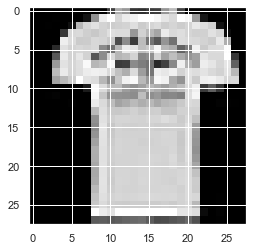

In [108]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


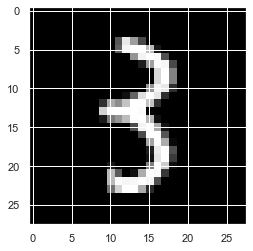

In [109]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()


# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

---
### Exercise 1 (58points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition.

In [175]:

def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """

    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)



    if optimizer == 'SGD': 
        optimizer_code = tf.keras.optimizers.SGD(learning_rate)
    else:
        optimizer_code = tf.keras.optimizers.Adam(learning_rate)


    model = tf.keras.Sequential()
    
    model.add(tf.keras.Input(shape=(28,28,1), name='Input'))
    
    model.add(tf.keras.layers.Flatten(name = 'Flatten'))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size, activation = activation))

    model.add(tf.keras.layers.Dense(units=n_classes, activation=activation, name='Output'))

    model.compile(loss='binary_crossentropy', optimizer = optimizer_code,metrics=['accuracy'] )
    
#     weights_as_dict = {}
#     biases_as_dict = {}
#     for i in range(len(hidden_layer_sizes) + 1):
#         w, b = model.layers[i].get_weights()
#         weights_as_dict[i] = w
#         biases_as_dict[i] = b

#     fig = plt.figure(figsize=(12, 12))
#     ax = fig.gca()
#     ax.axis('off')
#     draw_neural_net(ax, [2]+hidden_layer_sizes+[1], weights_as_dict, biases_as_dict)
    
    print(model.summary())
    
    return model



---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

In [176]:
def draw_neural_net(ax, layer_sizes, coefs_, intercepts_,
                    left=0.1, right=.9, bottom=0.1, top=.9):
    '''
    Draw a neural network cartoon using matplotilb.
    Adapted: https://gist.github.com/craffel/2d727968c3aaebd10359
    
    Args:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    
    # Input-Arrows
    layer_top_0 = v_spacing*(layer_sizes[0] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[0]):
        plt.arrow(left-0.18, layer_top_0 - m*v_spacing, 0.12, 0,  lw=1, head_width=0.01, head_length=0.02)
    
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color='w', ec='k', zorder=4)
            if n == 0:
                plt.text(left-0.125, layer_top - m*v_spacing, r'$X_{'+str(m+1)+'}$', fontsize=15)
            elif (n_layers == 3) & (n == 1):
                plt.text(n*h_spacing + left+0.00, layer_top - m*v_spacing+ (v_spacing/8.+0.01*v_spacing), r'$H_{'+str(m+1)+'}$', fontsize=15)
            elif n == n_layers -1:
                plt.text(n*h_spacing + left+0.10, layer_top - m*v_spacing, r'$y_{'+str(m+1)+'}$', fontsize=15)
            ax.add_artist(circle)
    # Bias-Nodes
    for n, layer_size in enumerate(layer_sizes):
        if n < n_layers -1:
            x_bias = (n+0.5)*h_spacing + left
            y_bias = top + 0.005
            circle = plt.Circle((x_bias, y_bias), v_spacing/8., color='w', ec='k', zorder=4)
            plt.text(x_bias-(v_spacing/8.+0.10*v_spacing-0.01), y_bias, r'$1$', fontsize=15)
            ax.add_artist(circle)   
    # Edges
    # Edges between nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
                xm = (n*h_spacing + left)
                xo = ((n + 1)*h_spacing + left)
                ym = (layer_top_a - m*v_spacing)
                yo = (layer_top_b - o*v_spacing)
                rot_mo_rad = np.arctan((yo-ym)/(xo-xm))
                rot_mo_deg = rot_mo_rad*180./np.pi
                xm1 = xm + (v_spacing/8.+0.05)*np.cos(rot_mo_rad)
                if n == 0:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.1)*np.sin(rot_mo_rad) + .01
                else:
                    if yo > ym:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                    else:
                        ym1 = ym + (v_spacing/8.+0.08)*np.sin(rot_mo_rad)
                plt.text(xm1, ym1,
                         str(round(coefs_[n][m, o],2)),
                         rotation = rot_mo_deg,
                         fontsize = 10)
    # Edges between bias and nodes
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        if n < n_layers-1:
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        x_bias = (n+0.5)*h_spacing + left
        y_bias = top + 0.005 
        for o in range(layer_size_b):
            line = plt.Line2D([x_bias, (n + 1)*h_spacing + left],
                          [y_bias, layer_top_b - o*v_spacing], c='k')
            ax.add_artist(line)
            xo = ((n + 1)*h_spacing + left)
            yo = (layer_top_b - o*v_spacing)
            rot_bo_rad = np.arctan((yo-y_bias)/(xo-x_bias))
            rot_bo_deg = rot_bo_rad*180./np.pi
            xo2 = xo - (v_spacing/8.+0.01)*np.cos(rot_bo_rad)
            yo2 = yo - (v_spacing/8.+0.01)*np.sin(rot_bo_rad)
            xo1 = xo2 -0.08 * np.cos(rot_bo_rad)
            yo1 = yo2 -0.05 * np.sin(rot_bo_rad)
            plt.text(xo1, yo1,
                 str(round(intercepts_[n][o],2)),
                 rotation = rot_bo_deg,
                 fontsize = 10)    
                
    # Output-Arrows
    layer_top_0 = v_spacing*(layer_sizes[-1] - 1)/2. + (top + bottom)/2.
    for m in range(layer_sizes[-1]):
        plt.arrow(right+0.015, layer_top_0 - m*v_spacing, 0.16*h_spacing, 0,  lw =1, head_width=0.01, head_length=0.02)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None
Training...


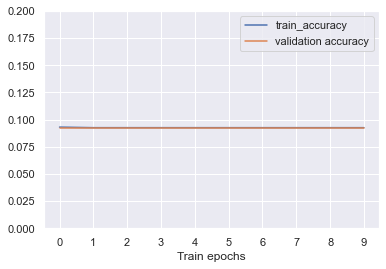

Test Accuracy: 0.0886


In [177]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=10):

  # Build the model.
  model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset.
  if data == 'digits':
    X_train = X_train_digits
    X_test = X_test_digits
    Y_train = Y_train_digits
    Y_test = Y_test_digits
  elif data == 'fashion':
    X_train = X_train_fashion
    X_test = X_test_fashion
    Y_train = Y_train_fashion
    Y_test = Y_test_fashion
  else:
    raise 'Unsupported dataset: %s' %data

  # Train the model.
  print('Training...')

  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.

  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.ylim(0,0.2)
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0, return_dict=True)['accuracy']
  return test_accuracy

print('Test Accuracy: %1.4f' %train_and_evaluate())



---
### Exercise 2 (8 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01|7,850|0.1012
digits|[]|relu|SGD|0.01|7,850|0.0881
digits|[]|relu|Adam|0.01|7,850|0.0886
digits|[128]|relu|Adam|0.01|101,770|0.0953
digits|[256,128]|relu|Adam|0.01|235,146|0.0892
-
fashion|[]|tanh|SGD|0.01|7,850|0.0994
fashion|[]|relu|SGD|0.01|7,850|0.0959
fashion|[]|relu|Adam|0.01|7,850|0.1426
fashion|[128]|relu|Adam|0.01|101,770|0.0663
fashion|[256,128]|relu|Adam|0.01|235,146|0.0116
